Let's built a new visualization which will be based on the spectral analysis software in Pau. I have to prepare a histogram image. The y-axis is the frequency and the x-axis is the applied energy while acquisition. In our example this range is between 20 and 180 kV. Each image slice corresponds to one of those mentioned voltages resulting in 140 images (one image per voltage, i.e., 20 21, 22, 23 kV). 

I have a stack of those images loaded in "model".

Parameters filename: exportedEXP1.json
----------------------------------------------
EXP1:                                         
Nice data; the minimum value in your data is 0
----------------------------------------------
Reshaping data to the desired order (nx, ny, nz)...


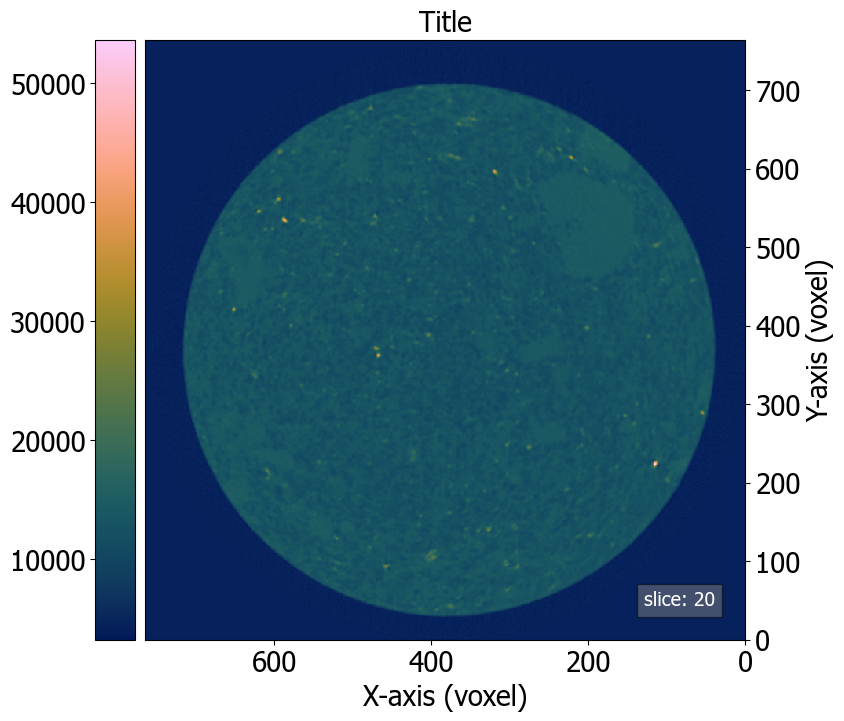

In [38]:
import numpy as np
from drp_template.image import plot_histogram, plot_slice
from drp_template.input_output import import_tiff_sequence
from drp_template.default_params import update_parameters_file

sample1 = '/Users/martin/Library/Mobile Documents/com~apple~CloudDocs/MYDATA/SCIENCE_WORLD/STUDIES/2024_EXCITE_Pau/02_Data/EXP1_Pau/spectral/exported'
sample2 = '/Users/martin/Library/Mobile Documents/com~apple~CloudDocs/MYDATA/SCIENCE_WORLD/STUDIES/2024_EXCITE_Pau/02_Data/EXP2_Pau/spectral/exported'
sample3 = '/Users/martin/Library/Mobile Documents/com~apple~CloudDocs/MYDATA/SCIENCE_WORLD/STUDIES/2024_EXCITE_Pau/02_Data/EXP3_Pau/spectral/exported'
sample4 = '/Users/martin/Library/Mobile Documents/com~apple~CloudDocs/MYDATA/SCIENCE_WORLD/STUDIES/2024_EXCITE_Pau/02_Data/EXP4_Pau/spectral/exported'

# path = '/Users/martin/Library/Mobile Documents/com~apple~CloudDocs/MYDATA/SCIENCE_WORLD/STUDIES/2024_EXCITE_Pau/02_Data/EXP1_Pau/spectral/exported'
dimensions_dict = {'ny': 764, 'nx': 764, 'nz': 140}
spectral_dict = {'minV': 20, 'maxV': 160}
model = import_tiff_sequence(sample1, filename='EXP1', dtype='uint16', dimensions=dimensions_dict)

params_filename = 'exportedEXP1.json'
update_parameters_file(paramsfile=params_filename,spectral=spectral_dict)
# fig, ax = plot_histogram(data=model, paramsfile=paramsfile, dtype=None, cmap_set=None, title=None, log_scale='y', dark_mode=False)
fig, ax = plot_slice(data=model, paramsfile=params_filename, cmap_set=None, slice=20, plane='xy', subvolume=None, labels=None, dark_mode=False)

In [39]:
# Import all modules and packages
import numpy as np
import matplotlib.pyplot as plt
import drp_template.bin.default_parameters as params
from drp_template.default_params import read_parameters_file
from cmcrameri import cm

json_file_path = '/Users/martin/Library/Mobile Documents/com~apple~CloudDocs/MYDATA/CODING_WORLD/PYTHON_WORLD/Digital_Rock_Physics_Template/drp_template/default_params/default_figure_settings.json'
default_figure_settings = read_parameters_file(paramsfile=json_file_path, paramsvars=None)

im_left = default_figure_settings.get('im_left')
im_left_xz = default_figure_settings.get('im_left_xz')
im_right = default_figure_settings.get('im_right')
im_bottom = default_figure_settings.get('im_bottom')
im_width = default_figure_settings.get('im_width')
im_height = default_figure_settings.get('im_height')
cax_width = default_figure_settings.get('cax_width')
fig_width = default_figure_settings.get('fig_width')
fig_height = default_figure_settings.get('fig_height')
cax_space_left = default_figure_settings.get('cax_space_left')
cax_space_right = default_figure_settings.get('cax_space_right')
im_title = default_figure_settings.get('im_title')
plt.rcParams['font.size'] = default_figure_settings.get('font_size')
plt.rcParams['font.family'] = default_figure_settings.get('font_family')

In [40]:
# Write a new function based on the existing idea of "plot_histogram", but name it "plot_spectral_histogram". Implement the defined new x-axis.
# The y-axis is the frequency and the x-axis is the applied energy while acquisition. In our example this range is between 20 and 180 kV. 
# Each image slice corresponds to one of those mentioned voltages resulting in 140 images (one image per voltage, i.e., 20 21, 22, 23 kV). 
from matplotlib.ticker import FixedLocator, FixedFormatter

def plot_spectral_histogram(data, paramsfile, dtype=None, cmap_set=None, title=None, log_scale=None, dark_mode=False):
    """
    Plot the histogram of the input data.
    :param data: 3D numpy array
    :param paramsfile: json file containing the parameters of the acquisition
    :param dtype: data type of the input data
    :param cmap_set: color map to be used
    :param title: title of the plot
    :param log_scale: 'x', 'y', 'both' or None
    :param dark_mode: boolean
    :return: fig, ax
    """
    # Set dtype on the paramerts file if not provided
    if dtype is None:
        dtype = read_parameters_file(paramsfile=paramsfile, paramsvars='dtype')
        
    # Determine gray_max on dtype
    if dtype == 'uint8':
        gray_max = 255
    elif dtype == 'uint16':
        gray_max = 65535
    else:
        raise ValueError('dtype not recognized')
    
    # Set default colormap if not specified
    if cmap_set is None:
        cmap_set = default_figure_settings.get('colormap')
        cmap_set = eval(cmap_set)
    
    # Set color scheme based on dark_mode
    if dark_mode:
        text_color, face_color, edge_color = 'white', 'black', 'white' 
    else:
        text_color, face_color, edge_color = 'black', 'white', 'black'
        
    # Number of bins is defined by the number of slices
    # Remember: spectral images are 2D images for a range of applied energy while acquisition
    iqr = np.percentile(data, 75) - np.percentile(data, 25)
    bins_width = 2 * iqr / (len(data) ** (1 / 3))
    bins = read_parameters_file(paramsfile=paramsfile, paramsvars='nz')
    
    # Compute histogram of gray-scale intensities
    hist, bins = np.histogram(data.flatten(), bins=bins, range=(0, gray_max))
    
    # Create a color map for the histogram bars
    cmap = plt.cm.get_cmap(cmap_set)
    colors = cmap(np.linspace(0, 1, len(bins) - 1))

    # Plot histogram using colored bars
    fig, ax = plt.subplots(figsize=(fig_width, fig_height), facecolor=face_color, edgecolor=edge_color)
    ax.bar(bins[:-1], hist, width=bins_width, color=colors, linewidth=0.5, edgecolor=None) # no edgecolor for the bars

    # Apply log scale based on the log_scale parameter
    if log_scale == 'both':
        ax.set_xscale('log')
        ax.set_yscale('log')
    elif log_scale == 'x':
        ax.set_xscale('log')
    elif log_scale == 'y':
        ax.set_yscale('log')

    # Set labels and title with adjusted font size
    font_size = plt.rcParams['font.size']
    # rename the tick labels to the applied energy from the spectral acquisition
    spectral = read_parameters_file(paramsfile=paramsfile, paramsvars='spectral')
    spectral_min = spectral.get('minV')
    spectral_max = spectral.get('maxV')
    print(f"spectral min: {spectral_min}, spectral max: {spectral_max}")
    
    # get the current xticks and xticklabels to rename them from spectral_min to spectral_max
    # only replace the xticklabels, not the actual values. Therefore, you have to map xticks[0] to spectral_min and xticks[-1] to spectral_max
    # make a linespace from spectral_min to spectral_max in steps of 1.
    # get the current xticklabels and replace them with the linespace
    
    xticks = ax.get_xticks()    # make the xticklabels always integers like 20, 21, 22..
    xticklabels = np.linspace(spectral_min, spectral_max, len(xticks)).astype(int)
    # set the current xticklabel[0] to spectral min
    xticklabels[0] = spectral_min
    # set the current xticklabel[-1] to spectral max
    xticklabels[-1] = spectral_max
    ax.set_xticks(xticks)
    ax.set_xticklabels(xticklabels)

    ax.set_xlabel('Applied kV', color=text_color, fontsize=font_size)
    ax.set_ylabel('Frequency', color=text_color, fontsize=font_size)

    # Set title with adjusted font size
    title_text = 'Spectral Histogram' if title is None else title
    ax.set_title(title_text, color=text_color, fontsize=font_size)

    # Set tick parameters with adjusted font size
    ax.tick_params(axis='both', which='both', direction='in', labelsize=font_size, colors=text_color)

    # Set spines edge color for the entire subplot
    for spine in ax.spines.values():
        spine.set_edgecolor(edge_color)

    # Set background color
    ax.set_facecolor(face_color)


    return fig, ax
    
        
    

/var/folders/jl/thv6zrvj5jv3y5xmtmbs6g0m0000gn/T/ipykernel_64812/213654633.py:51: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = plt.cm.get_cmap(cmap_set)


spectral min: 20, spectral max: 160


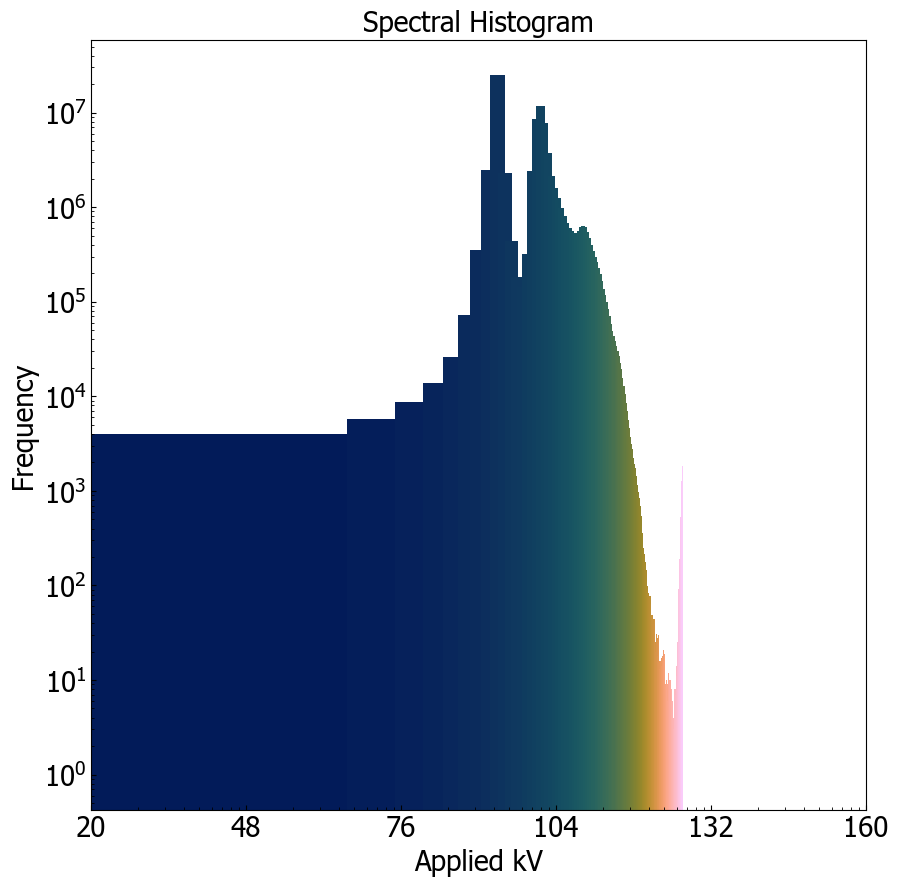

In [44]:
fig, ax = plot_spectral_histogram(data=model, paramsfile=params_filename, dtype=None, cmap_set=None, title=None, log_scale='both', dark_mode=False)